# **IMPORT LIBRARIES AND DATA**

In [16]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav

import matplotlib.pyplot as plt
import IPython.display as ipd # Notebook only

# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# File management
from google.colab import drive
import tarfile
from shutil import copyfile

# Frequency analysis
from scipy.fft import fft, fftfreq, rfft, rfftfreq
from scipy.signal import spectrogram
from librosa.feature import melspectrogram, mfcc
from librosa.display import specshow

In [3]:
# Link Google Drive account, transfer dataset, and extract files
drive.mount('/content/gdrive')
copyfile('gdrive/My Drive/DIGITAL SIGNAL AND IMAGE MANAGEMENT/recordings.tar', 'recordings.tar')
tar = tarfile.open('recordings.tar')
tar.extractall()
tar.close()

Mounted at /content/gdrive


# DATA LOADER

In [4]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_test, y_train, y_test

# LENGTH ANALYSIS
Using a simple function extracting the duration of the signal I will analyze the distribution of this characteristics accross the datatet. This is crucial as 2D feature like spectrogram and other variations produce different demensionality based on the imput data but is necessarry to pass omogeneus feature to a classification model

In [5]:
def duration(input):
  return input.shape

X_train, X_test, y_train, y_test = load_data(feature_extractor=duration, normalize=False)

In [6]:
import pandas as pd
X = pd.DataFrame(X_train)

X.describe()

,0
count,1350.000000
mean,3343.247407
std,1160.009516
min,1149.000000
25%,2619.500000
50%,3236.000000
75%,3843.750000
max,18262.000000


We'll consider the 50th and 75th percentiles of signal's length to build feature extractor that will suits data for majority of the cases.

Let's start by defining a function that crop data according to a specific length in order to see what is the correspondent dimensionsionality of the computed spectogram

In [7]:
def compute_spectrogram(input, size, sound_rate = 8000):

  output = input[0: min(size, len(input))]
  output = np.concatenate((output, np.zeros(size - output.shape[0])))

  [spec_freqs, spec_times, spec] = spectrogram(output, fs = sound_rate)
  mfccs = mfcc(y = output*1.0, sr = sound_rate)

  return spec, mfccs

compute spectogram and mel spectrogram according to 50th percentile length

In [9]:
# Import file
sound_rate, sound_data = wav.read('recordings/0_jackson_0.wav')

In [10]:
spec, mfccs = compute_spectrogram(sound_data, 3343)
print(spec.shape)
print(mfccs.shape)

(129, 14)
(20, 7)


compute spectogram and mel spectrogram according to 75th percentile length

In [11]:
spec, mfccs = compute_spectrogram(sound_data, 3843)
print(spec.shape)
print(mfccs.shape)

(129, 17)
(20, 8)


I want to compute the spectrogram and then crop or pad the obtained features according to the chosen length and not the opposite, as I do not want to risk losing potentially significant information, given that I do not know in advance which part of the signal is the most relevant. By calculating the spectrogram on the entire signal, I ensure that all the data is preserved, and then I can experiment with various cropping techniques (e.g., cropping at the end, middle, or specific segments) and padding strategies (e.g., zero-padding or mean-padding) to optimize the features for my classification task.

# **SPECTROGRAM IMPLEMENTATION**

In [12]:
def spectrogram_features(input, n_cols, pad_method, sound_rate = 8000):

  [spec_freqs, spec_times, spec] = spectrogram(input, fs = sound_rate)
  spec = spec[:, 0:min(n_cols, spec.shape[1])]

  if spec.shape[1] < n_cols:
    if pad_method == 'zero':

        padding = np.zeros((spec.shape[0], n_cols - spec.shape[1]))
        spec = np.hstack((spec, padding))

    else:

      padding_value = np.mean(spec)
      padding = np.full((spec.shape[0], n_cols - spec.shape[1]), padding_value)
      spec = np.hstack((spec, padding))

  return spec.flatten()

I define different aspect to be tried
 * hyperparameters of classification model
 * different number of column corresponding to 50 and 75th percentiles' length (cropping's length)
 * different padding technique (zero, mean)

In [13]:
# Model's hyperparameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0]}

# Feature extraction parameters
cols = [14, 17]
methods = ['zero', 'mean']

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Classification report with n_cols =  14 and padding method =  zero
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        17
           1       0.64      0.70      0.67        10
           2       0.77      0.67      0.71        15
           3       0.83      0.53      0.65        19
           4       0.17      0.73      0.28        11
           5       0.71      0.71      0.71        14
           6       0.30      0.43      0.35        14
           7       0.67      0.32      0.43        19
           8       1.00      0.24      0.38        17
           9       0.62      0.36      0.45        14

    accuracy                           0.51       150
   macro avg       0.65      0.53      0.53       150
weighted avg       0.68      0.51      0.54       150

Confusion Matrix (normalized):


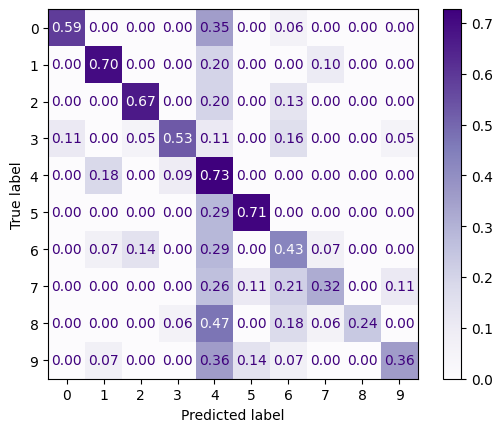

Classification report with n_cols =  14 and padding method =  mean
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.75      0.60      0.67        10
           2       0.80      0.53      0.64        15
           3       0.93      0.68      0.79        19
           4       0.27      0.27      0.27        11
           5       0.77      0.71      0.74        14
           6       0.17      0.71      0.27        14
           7       0.78      0.37      0.50        19
           8       0.80      0.24      0.36        17
           9       0.56      0.36      0.43        14

    accuracy                           0.51       150
   macro avg       0.67      0.51      0.54       150
weighted avg       0.70      0.51      0.55       150

Confusion Matrix (normalized):


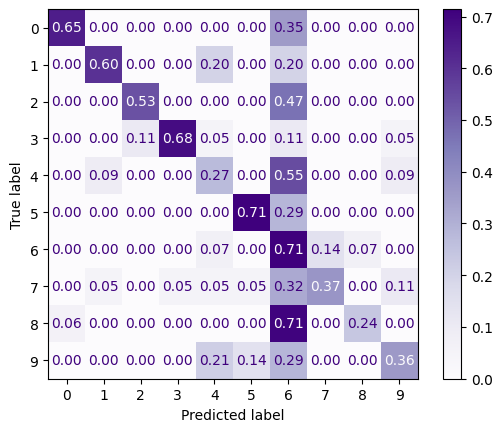

Classification report with n_cols =  17 and padding method =  zero
              precision    recall  f1-score   support

           0       0.28      0.94      0.43        17
           1       0.64      0.70      0.67        10
           2       0.77      0.67      0.71        15
           3       0.85      0.58      0.69        19
           4       0.43      0.27      0.33        11
           5       0.64      0.64      0.64        14
           6       0.50      0.50      0.50        14
           7       0.70      0.37      0.48        19
           8       1.00      0.24      0.38        17
           9       0.67      0.29      0.40        14

    accuracy                           0.52       150
   macro avg       0.65      0.52      0.52       150
weighted avg       0.66      0.52      0.52       150

Confusion Matrix (normalized):


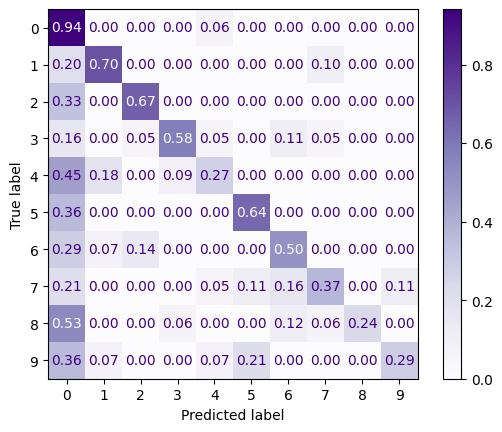

Classification report with n_cols =  17 and padding method =  mean
              precision    recall  f1-score   support

           0       0.82      0.53      0.64        17
           1       0.71      0.50      0.59        10
           2       0.64      0.47      0.54        15
           3       0.86      0.63      0.73        19
           4       0.38      0.55      0.44        11
           5       0.71      0.71      0.71        14
           6       0.18      0.71      0.28        14
           7       0.67      0.32      0.43        19
           8       0.80      0.24      0.36        17
           9       0.83      0.36      0.50        14

    accuracy                           0.49       150
   macro avg       0.66      0.50      0.52       150
weighted avg       0.68      0.49      0.53       150

Confusion Matrix (normalized):


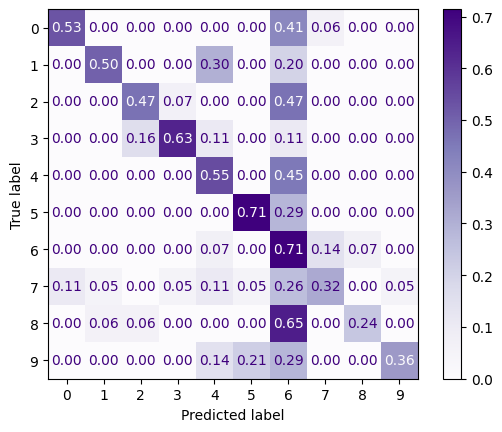

In [17]:
for col in cols:
  for method in methods:

    def feature_extractor_wrapper(input):
      return spectrogram_features(input, n_cols=col, pad_method=method)

    X_train, X_test, y_train, y_test = load_data(feature_extractor = feature_extractor_wrapper, normalize = True)

    # Support Vector Machine initialization
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)
    clf = clf.fit(X_train, y_train)

    # Prediction
    y_pred = clf.predict(X_test)

    # Classification report
    print('Classification report with n_cols = ', col, 'and padding method = ', method)
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Display confusion matrix normalized by row
    print('Confusion Matrix (normalized):')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
    disp.plot(cmap=plt.cm.Purples, values_format=".2f")  # `.2f` to round to 2nd decimal
    plt.show()

The best result was achieved with n_cols = 14 and mean padding, showing the highest macro F1-score (0.54) and a balanced performance across classes. The use of mean padding likely preserved the signal's context better compared to zero-padding, making it more effective for feature representation. Classes with higher support (e.g., 0, 3, 5, 7) performed well, but rare classes like 6 and 9 still struggled.

Now, let's experiment with a different cropping technique by selecting the central part of the extracted features, cropping equally from both the start and the end, rather than focusing only on the end

In [18]:
def spectrogram_features2(input, n_cols, pad_method, sound_rate = 8000):

  [spec_freqs, spec_times, spec] = spectrogram(input, fs = sound_rate)
  if n_cols <= spec.shape[1]:

    n = spec.shape[1] - n_cols
    a = n // 2
    b = n - a

    spec = spec[:, a:(spec.shape[1] - b)]

  else:

    n = n_cols - spec.shape[1]
    a = n // 2
    b = n - a

    if pad_method == 'zero':

        padding1 = np.zeros((spec.shape[0], a))
        padding2 = np.zeros((spec.shape[0], b))
        spec = np.hstack((padding1, spec, padding2))

    else:

      padding_value = np.mean(spec)
      padding1 = np.full((spec.shape[0], a), padding_value)
      padding2 = np.full((spec.shape[0], b), padding_value)
      spec = np.hstack((padding1, spec, padding2))

  return spec.flatten()


Classification report with n_cols =  14 and padding method =  zero
              precision    recall  f1-score   support

           0       0.23      0.88      0.37        17
           1       0.86      0.60      0.71        10
           2       0.45      0.33      0.38        15
           3       0.77      0.53      0.62        19
           4       0.29      0.18      0.22        11
           5       0.67      0.43      0.52        14
           6       0.33      0.50      0.40        14
           7       0.90      0.47      0.62        19
           8       0.75      0.18      0.29        17
           9       1.00      0.29      0.44        14

    accuracy                           0.45       150
   macro avg       0.63      0.44      0.46       150
weighted avg       0.63      0.45      0.46       150

Confusion Matrix (normalized):


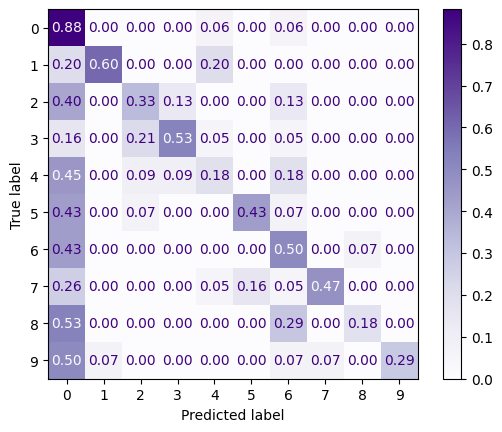

Classification report with n_cols =  14 and padding method =  mean
              precision    recall  f1-score   support

           0       0.90      0.53      0.67        17
           1       1.00      0.70      0.82        10
           2       0.60      0.40      0.48        15
           3       0.62      0.53      0.57        19
           4       0.71      0.45      0.56        11
           5       0.64      0.64      0.64        14
           6       0.19      0.79      0.31        14
           7       0.53      0.47      0.50        19
           8       0.71      0.29      0.42        17
           9       1.00      0.36      0.53        14

    accuracy                           0.51       150
   macro avg       0.69      0.52      0.55       150
weighted avg       0.68      0.51      0.54       150

Confusion Matrix (normalized):


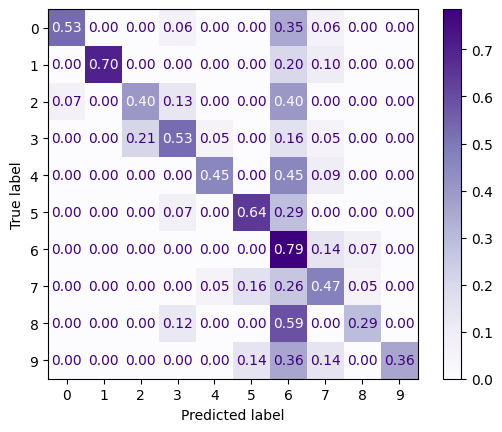

Classification report with n_cols =  17 and padding method =  zero
              precision    recall  f1-score   support

           0       0.26      0.94      0.41        17
           1       1.00      0.60      0.75        10
           2       0.62      0.53      0.57        15
           3       0.86      0.63      0.73        19
           4       0.50      0.18      0.27        11
           5       0.86      0.43      0.57        14
           6       0.32      0.50      0.39        14
           7       0.85      0.58      0.69        19
           8       0.67      0.12      0.20        17
           9       0.83      0.36      0.50        14

    accuracy                           0.50       150
   macro avg       0.68      0.49      0.51       150
weighted avg       0.67      0.50      0.51       150

Confusion Matrix (normalized):


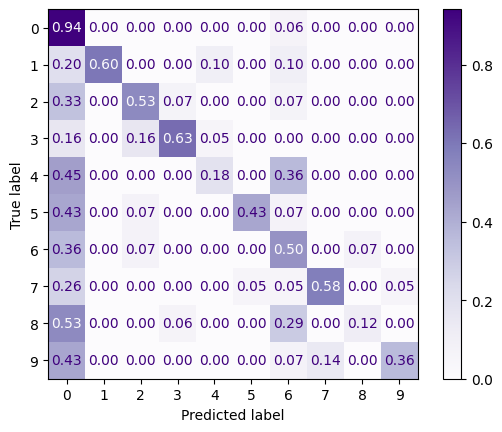

Classification report with n_cols =  17 and padding method =  mean
              precision    recall  f1-score   support

           0       0.69      0.53      0.60        17
           1       0.86      0.60      0.71        10
           2       0.73      0.53      0.62        15
           3       0.77      0.53      0.62        19
           4       0.57      0.36      0.44        11
           5       0.69      0.64      0.67        14
           6       0.18      0.79      0.29        14
           7       0.69      0.58      0.63        19
           8       0.75      0.18      0.29        17
           9       1.00      0.36      0.53        14

    accuracy                           0.51       150
   macro avg       0.69      0.51      0.54       150
weighted avg       0.69      0.51      0.54       150

Confusion Matrix (normalized):


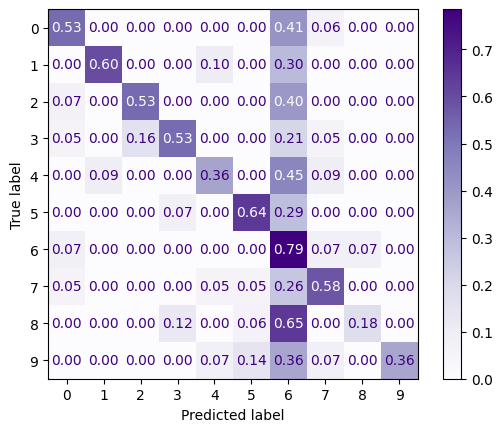

In [19]:
for col in cols:
  for method in methods:

    def feature_extractor_wrapper(input):
      return spectrogram_features2(input, n_cols=col, pad_method=method)

    X_train, X_test, y_train, y_test = load_data(feature_extractor = feature_extractor_wrapper, normalize = True)

    # Support Vector Machine initialization
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)
    clf = clf.fit(X_train, y_train)

    # Prediction
    y_pred = clf.predict(X_test)

    # Classification report
    print('Classification report with n_cols = ', col, 'and padding method = ', method)
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Display confusion matrix normalized by row
    print('Confusion Matrix (normalized):')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
    disp.plot(cmap=plt.cm.Purples, values_format=".2f")  # `.2f` to round to 2nd decimal
    plt.show()

Switching to central cropping did not bring significant benefits over end-cropping. This suggests that the critical information for classification is evenly distributed or preserved in both cases. Further improvement might require changes in feature representation.

# **MCFF IMPLEMENTATION**

Let's now try the same protocol using a different feature extraction method, the **Mel-frequency cepstral coefficients**.

In [20]:
def mfccs_features(input, n_cols, pad_method, sound_rate = 8000):

  mfccs = mfcc(y = input*1.0, sr = sound_rate, n_fft=1024)
  mfccs = mfccs[:, 0:min(n_cols, mfccs.shape[1])]

  if mfccs.shape[1] < n_cols:
    if pad_method == 'zero':

        padding = np.zeros((mfccs.shape[0], n_cols - mfccs.shape[1]))
        mfccs = np.hstack((mfccs, padding))

    else:

      padding_value = np.mean(mfccs)
      padding = np.full((mfccs.shape[0], n_cols - mfccs.shape[1]), padding_value)
      mfccs = np.hstack((mfccs, padding))

  return mfccs.flatten()

In [21]:
cols = [7, 8]
methods = ['zero', 'mean']

Classification report with n_cols =  7 and padding method =  zero
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        14
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        14

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150

Confusion Matrix (normalized):


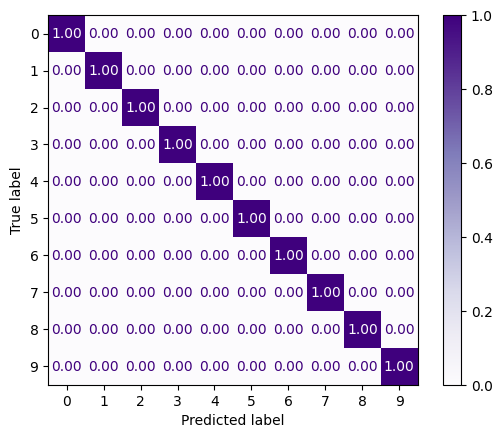

Classification report with n_cols =  7 and padding method =  mean
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      0.93      0.96        14
           7       1.00      1.00      1.00        19
           8       0.94      1.00      0.97        17
           9       1.00      1.00      1.00        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix (normalized):


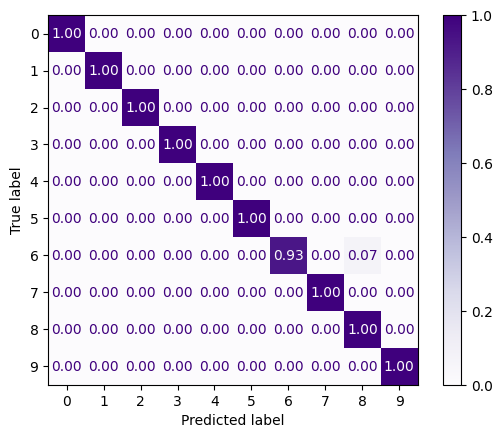

Classification report with n_cols =  8 and padding method =  zero
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       0.95      1.00      0.97        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      0.93      0.96        14
           7       1.00      1.00      1.00        19
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix (normalized):


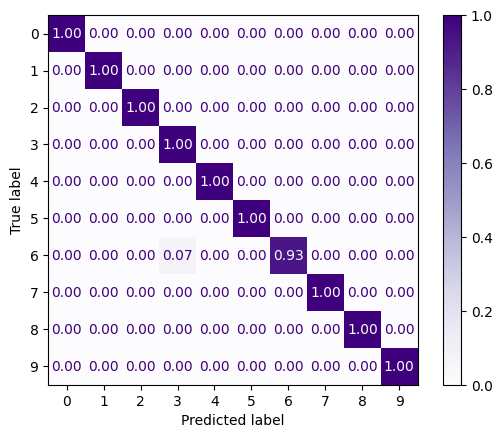

Classification report with n_cols =  8 and padding method =  mean
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        19
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        14
           6       1.00      0.93      0.96        14
           7       1.00      1.00      1.00        19
           8       0.94      1.00      0.97        17
           9       1.00      1.00      1.00        14

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150

Confusion Matrix (normalized):


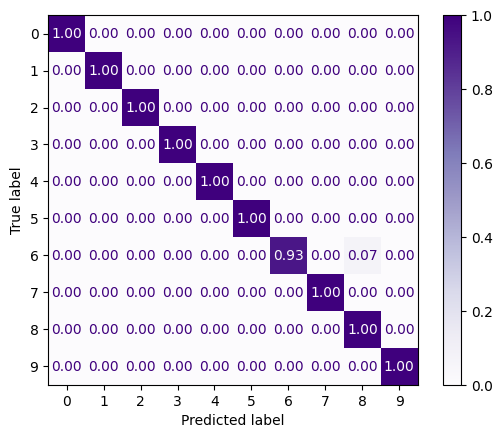

In [22]:

for col in cols:
  for method in methods:

    def feature_extractor_wrapper(input):
      return mfccs_features(input, n_cols=col, pad_method=method)

    X_train, X_test, y_train, y_test = load_data(feature_extractor = feature_extractor_wrapper, normalize = True)

    # Support Vector Machine initialization
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv = 5)
    clf = clf.fit(X_train, y_train)

    # Prediction
    y_pred = clf.predict(X_test)

    # Classification report
    print('Classification report with n_cols = ', col, 'and padding method = ', method)
    print(classification_report(y_test, y_pred))

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Display confusion matrix normalized by row
    print('Confusion Matrix (normalized):')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
    disp.plot(cmap=plt.cm.Purples, values_format=".2f")  # `.2f` to round to 2nd decimal
    plt.show()

MFCC features outperform the previously used features (e.g., spectrogram-based features) by a substantial margin, delivering near-perfect classification. The robustness across configurations and minimal misclassifications highlight the suitability of MFCC features for this task. Further tuning of parameters (e.g., number of columns or padding strategy) may not yield significant improvements given the already high performance.